# Predicting bank customer subscriptions

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

### 1. Exploratory Data Analysis

In [10]:
df = pd.read_excel('data/train_file.xlsx')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32905,30,management,single,university.degree,no,no,no,cellular,nov,thu,197,5,1,failure,no
32906,34,blue-collar,married,high.school,no,yes,no,telephone,jun,mon,562,3,0,nonexistent,no
32907,33,technician,married,professional.course,no,yes,yes,cellular,aug,mon,61,1,0,nonexistent,no
32908,58,unemployed,married,basic.9y,no,no,no,telephone,jun,mon,266,2,0,nonexistent,no


Columns Meaning:

- default: Does the client have credit in default?
- housing: Does the client have a house?
- duration: duration of the phone call in seconds
- campaign: marketing campaign when the call was made
- loan: does the customer have a housing loan?
- previous: how many times has the customer been contacted previously?
- poutcome: "previous outcome" might refer to the result of a previous marketing campaign. Did they buy the product in a previous campaign?
- y: this is the target. Did the call end up in a the customer buying the product?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32910 non-null  int64 
 1   job          32910 non-null  object
 2   marital      32910 non-null  object
 3   education    32910 non-null  object
 4   default      32910 non-null  object
 5   housing      32910 non-null  object
 6   loan         32910 non-null  object
 7   contact      32910 non-null  object
 8   month        32910 non-null  object
 9   day_of_week  32910 non-null  object
 10  duration     32910 non-null  int64 
 11  campaign     32910 non-null  int64 
 12  previous     32910 non-null  int64 
 13  poutcome     32910 non-null  object
 14  y            32910 non-null  object
dtypes: int64(4), object(11)
memory usage: 3.8+ MB


Results show that we have integers and strings (object Dtype). The strings will need to be encoded for a better EDA and for training the model
. Also important: there are no null values.

In [12]:
categorical_columns = [x for x in df.columns if df[x].dtype == np.dtype('object')]
numerical_columns   = [x for x in df.columns if x not in(categorical_columns)]

In [13]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32905,30,management,single,university.degree,no,no,no,cellular,nov,thu,197,5,1,failure,no
32906,34,blue-collar,married,high.school,no,yes,no,telephone,jun,mon,562,3,0,nonexistent,no
32907,33,technician,married,professional.course,no,yes,yes,cellular,aug,mon,61,1,0,nonexistent,no
32908,58,unemployed,married,basic.9y,no,no,no,telephone,jun,mon,266,2,0,nonexistent,no


In [14]:
for col in categorical_columns:
    print(f"Column: {col}")
    print(df[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
    print("#"*40)

Column: job
job
admin.           25.24%
blue-collar      22.58%
technician       16.38%
services           9.7%
management        7.12%
retired           4.14%
entrepreneur      3.52%
self-employed     3.34%
housemaid          2.6%
unemployed        2.42%
student           2.16%
unknown            0.8%
Name: proportion, dtype: object
########################################
Column: marital
marital
married     60.56%
single      28.09%
divorced    11.15%
unknown       0.2%
Name: proportion, dtype: object
########################################
Column: education
education
university.degree      29.56%
high.school            23.05%
basic.9y               14.64%
professional.course    12.71%
basic.4y               10.09%
basic.6y                5.66%
unknown                 4.24%
illiterate              0.05%
Name: proportion, dtype: object
########################################
Column: default
default
no         78.93%
unknown    21.06%
yes         0.01%
Name: proportion, dtype: object

Previous conclusion: Most of the people (88.74%) won't subscribe
TARGET IMBALANCED! WE NEED TO BE CAREFUL (when we create the model, the model might be biased toward predicting the majority class (customer not buying the product)).

In [15]:
df.describe().astype(int)  # will perform only for numerical columns

,age,duration,campaign,previous
count,32910,32910,32910,32910
mean,40,258,2,0
std,10,259,2,0
min,17,0,1,0
25%,32,103,1,0
50%,38,180,2,0
75%,47,319,3,0
max,98,4918,56,7


In [16]:
# we remove "month" and "day_of_week" of the categorical columns in order to label it manually with a perfect logic:
categorical_columns.remove('month') 
categorical_columns.remove('day_of_week') 

data = {'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']}
month_mapping = {'jan': 1,'feb': 2,'mar': 3,'apr': 4,'may': 5,'jun': 6,'jul': 7,'aug': 8,'sep': 9,'oct': 10,'nov': 11,'dec': 12}
# Manually encode the "month" column
df['month'] = df['month'].map(month_mapping)

data = {'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri']}
week_mapping = {'mon': 1,'tue': 2,'wed': 3,'thu': 4,'fri': 5,}
# Manually encode the "day_of_week" column
df['day_of_week'] = df['day_of_week'].map(week_mapping)

# we convert the call duration to minutes for standarization
df['duration']=df['duration']/60

Let's encode the remaining categorical variables

In [17]:
label_encoders = {}  # Store encoders for inverse transform if needed

for col in categorical_columns:  
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

    # Convert np.int64 values to regular integers
    mapping = {key: int(value) for key, value in zip(label_encoders[col].classes_, label_encoders[col].transform(label_encoders[col].classes_))}

    # Print the mapping of original values to encoded values
    print(f"Column: {col}")
    print(mapping)
    print("#"*30)

Column: job
{'admin.': 0, 'blue-collar': 1, 'entrepreneur': 2, 'housemaid': 3, 'management': 4, 'retired': 5, 'self-employed': 6, 'services': 7, 'student': 8, 'technician': 9, 'unemployed': 10, 'unknown': 11}
##############################
Column: marital
{'divorced': 0, 'married': 1, 'single': 2, 'unknown': 3}
##############################
Column: education
{'basic.4y': 0, 'basic.6y': 1, 'basic.9y': 2, 'high.school': 3, 'illiterate': 4, 'professional.course': 5, 'university.degree': 6, 'unknown': 7}
##############################
Column: default
{'no': 0, 'unknown': 1, 'yes': 2}
##############################
Column: housing
{'no': 0, 'unknown': 1, 'yes': 2}
##############################
Column: loan
{'no': 0, 'unknown': 1, 'yes': 2}
##############################
Column: contact
{'cellular': 0, 'telephone': 1}
##############################
Column: poutcome
{'failure': 0, 'nonexistent': 1, 'success': 2}
##############################
Column: y
{'no': 0, 'yes': 1}
##################

In [18]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,1,1,2,1,0,0,0,11,3,3.783333,4,0,1,0
1,37,2,1,6,0,0,0,1,11,3,3.366667,2,1,0,0
2,78,5,1,0,0,0,0,0,7,1,19.133333,1,0,1,1
3,36,0,1,6,0,2,0,1,5,1,2.000000,2,0,1,0
4,59,5,0,6,0,0,0,0,6,2,6.133333,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32905,30,4,2,6,0,0,0,0,11,4,3.283333,5,1,0,0
32906,34,1,1,3,0,2,0,1,6,1,9.366667,3,0,1,0
32907,33,9,1,5,0,2,2,0,8,1,1.016667,1,0,1,0
32908,58,10,1,2,0,0,0,1,6,1,4.433333,2,0,1,0


No "one hot encoding" has been performed in this analysis. 
I did some tests but no improvement in terms of accuracy was observed and it slowed down the models training due to the increased number of features

Let's check histograms now to see tendencies and to check if there are outliers in the database:

<function matplotlib.pyplot.show(close=None, block=None)>

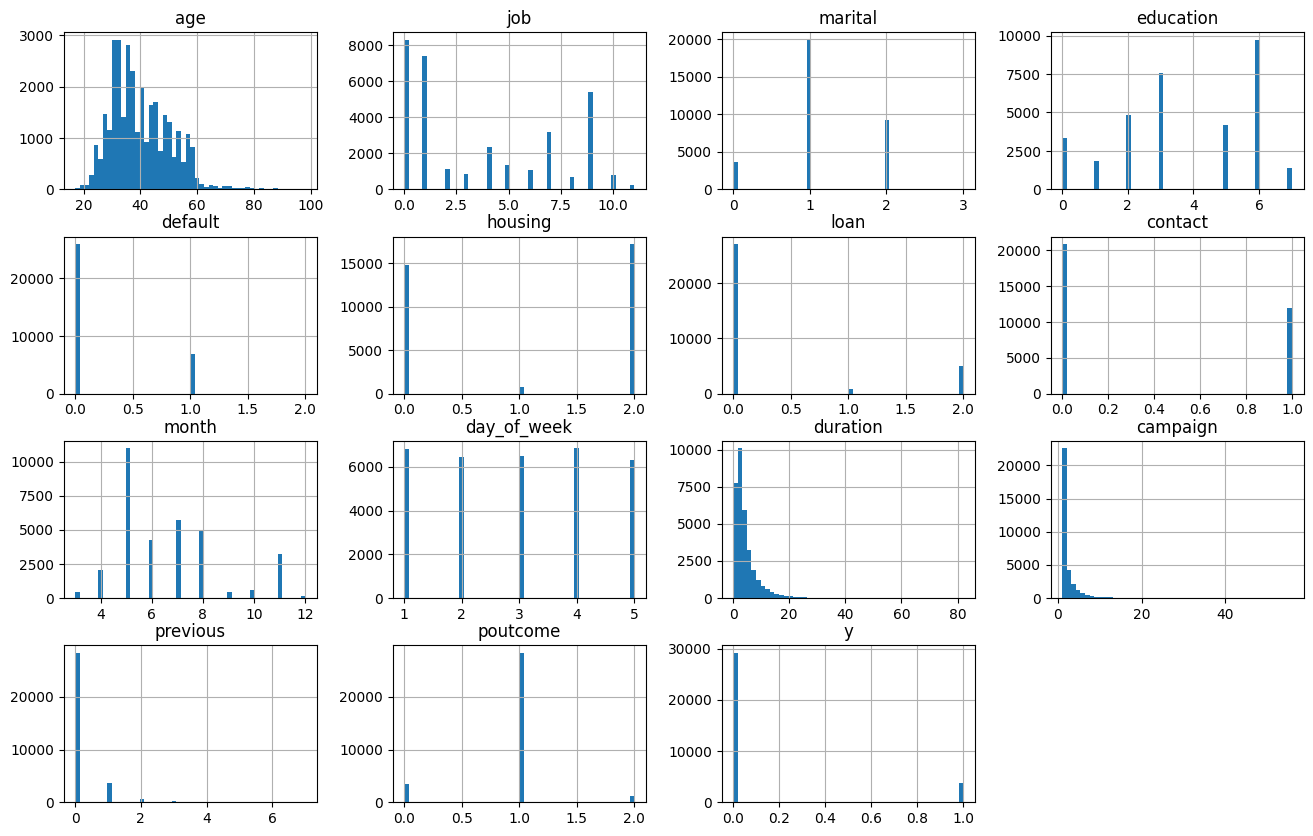

In [19]:
df.hist(bins=50, figsize=(16,10))
plt.show

Let's standarize variables that make sense to standarize

In [20]:
# List of numerical features to be standardized:
standarizable_features = ['age','campaign']
# Initialize the StandardScaler:
scaler = StandardScaler()
# Standardize the numerical features:
df[standarizable_features] = scaler.fit_transform(df[standarizable_features])
# We save the scaler for performing predictions:
with open("scaler/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [21]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,0.863797,1,1,2,1,0,0,0,11,3,3.783333,0.522785,0,1,0
1,-0.289739,2,1,6,0,0,0,1,11,3,3.366667,-0.203618,1,0,0
2,3.651511,5,1,0,0,0,0,0,7,1,19.133333,-0.566819,0,1,1
3,-0.385868,0,1,6,0,2,0,1,5,1,2.000000,-0.203618,0,1,0
4,1.825078,5,0,6,0,0,0,0,6,2,6.133333,-0.203618,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32905,-0.962636,4,2,6,0,0,0,0,11,4,3.283333,0.885986,1,0,0
32906,-0.578124,1,1,3,0,2,0,1,6,1,9.366667,0.159583,0,1,0
32907,-0.674252,9,1,5,0,2,2,0,8,1,1.016667,-0.566819,0,1,0
32908,1.728950,10,1,2,0,0,0,1,6,1,4.433333,-0.203618,0,1,0


Let's look for outliers visually using boxplots:

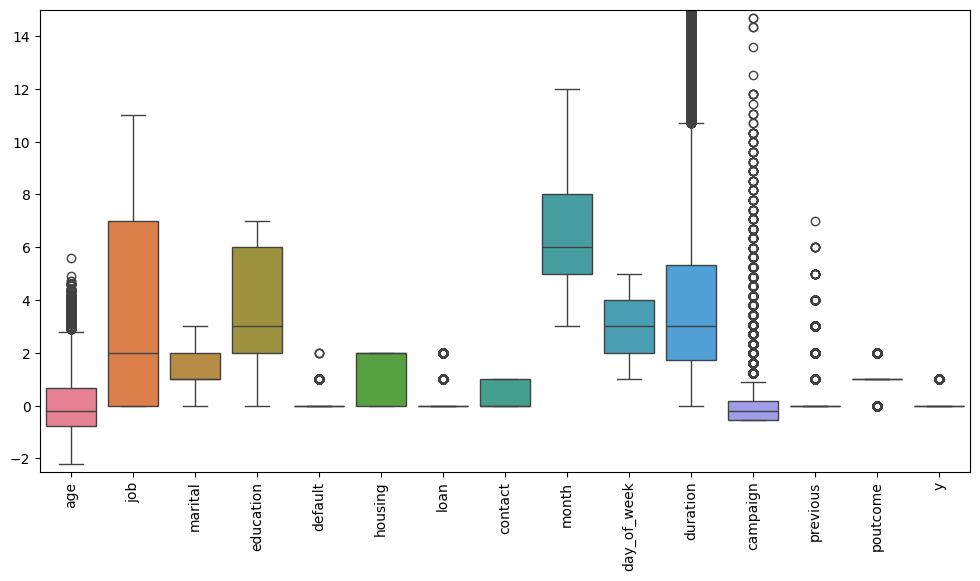

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)  
plt.ylim(-2.5, 15)
plt.show()

Outliers analyisis:

- age: values between 17 and 98 years old. Seems reasonable, we will not touch it
- default: only 3 unique values in this column: "yes", "no", "unknown". Seems reasonable, we will not touch it 
- loan: only 3 unique values in this column: "yes", "no", "unknown". Seems reasonable, we will not touch it 
- duration: values between 0 and 82 minutes. Seems reasonable, we will not touch it 
- campaign: values between 1 and 56. Seems reasonable, we will not touch it 
- previous: values between 0 and 7 previous calls. Seems reasonable, we will not touch it
- poutcome: only 3 unique values in this column: 'nonexistent', 'failure', 'success'. Seems reasonable, we will not touch it 
- y is the target with "no" or "yes" values. We will not touch it

Let's see correlations among variables with a heatmap:

<Axes: >

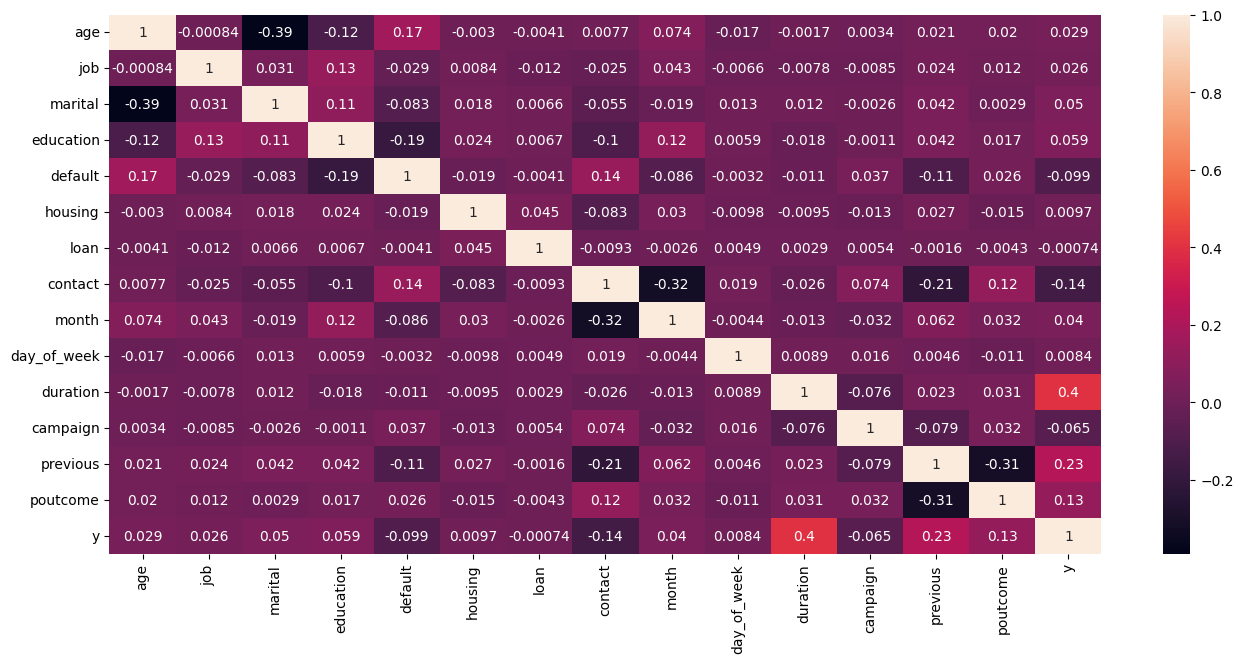

In [23]:
plt.figure(figsize=(16,7))
sns.heatmap(df.corr(),annot=True)

- Very interesting and obvious positive correlation between "duration" and "y". People who end up buying the product stay longer on the phone for getting information and performing the purchase.
- Interesting positive correlation between "previous" and "y". People who have already bought a product have more chances to buy another one.

### 2. Evaluation of different machine learning models:

In [24]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,0.863797,1,1,2,1,0,0,0,11,3,3.783333,0.522785,0,1,0
1,-0.289739,2,1,6,0,0,0,1,11,3,3.366667,-0.203618,1,0,0
2,3.651511,5,1,0,0,0,0,0,7,1,19.133333,-0.566819,0,1,1
3,-0.385868,0,1,6,0,2,0,1,5,1,2.000000,-0.203618,0,1,0
4,1.825078,5,0,6,0,0,0,0,6,2,6.133333,-0.203618,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32905,-0.962636,4,2,6,0,0,0,0,11,4,3.283333,0.885986,1,0,0
32906,-0.578124,1,1,3,0,2,0,1,6,1,9.366667,0.159583,0,1,0
32907,-0.674252,9,1,5,0,2,2,0,8,1,1.016667,-0.566819,0,1,0
32908,1.728950,10,1,2,0,0,0,1,6,1,4.433333,-0.203618,0,1,0


When splitting the data into training and testing sets, use stratified sampling to maintain the same class distribution in both sets. 
This ensures that the distribution of 1s and 0s is similar in both the training and test sets, preventing the model from being biased.
I tried SMOTE to prevent the imbalanced distribution in the target column but it did not generalize well, it seemed to overfit and the model became biased toward predicting "1" too often.

In [25]:
X = df.drop(['y'], axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Let's define a function with all the metrics for evaluating the models' performances:

In [26]:
def evaluation(name,model):

    # Define cross-validation strategy (5-fold Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("#" * 80)
    print(name)

    # Perform cross-validation and calculate mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    # Fit model on full training data
    #model.fit(X_train, y_train)

    # Fit model on training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    return()

Let's try 3 typical models for classification. We could try more but I will just try this 3 because they are significative. We could also try Decision trees, Support Vector Machines... 
We are going to compare the models with default hyperparameters and once we have decided the model we will add cross validation and finetune the hyperparameters.

################################################################################
LOGISTIC_REGRESSION
Cross-Validation Accuracy Scores: [0.90104167 0.90234375 0.90167137 0.90861732 0.89906664]
Mean Accuracy: 0.9025 ± 0.0032
Test Set Accuracy: 0.9002
Confusion Matrix:
[[8581  180]
 [ 805  307]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      8761
           1       0.63      0.28      0.38      1112

    accuracy                           0.90      9873
   macro avg       0.77      0.63      0.66      9873
weighted avg       0.88      0.90      0.88      9873



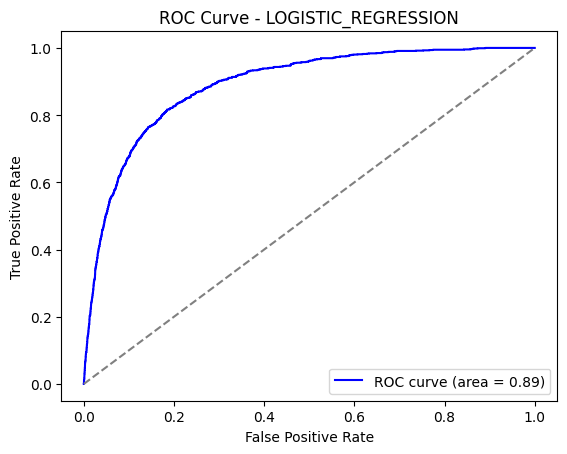

################################################################################
RANDOM_FOREST
Cross-Validation Accuracy Scores: [0.90625    0.90516493 0.90557847 0.90644671 0.90340786]
Mean Accuracy: 0.9054 ± 0.0011
Test Set Accuracy: 0.9067
Confusion Matrix:
[[8521  240]
 [ 681  431]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8761
           1       0.64      0.39      0.48      1112

    accuracy                           0.91      9873
   macro avg       0.78      0.68      0.72      9873
weighted avg       0.89      0.91      0.90      9873



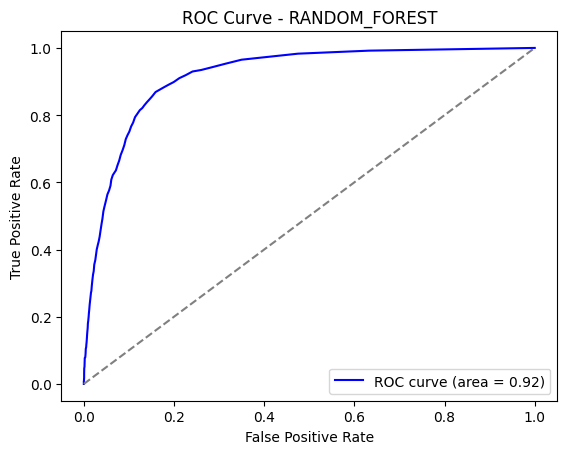

################################################################################
XGBOOST
Cross-Validation Accuracy Scores: [0.90321181 0.90690104 0.90405904 0.9042761  0.90210549]
Mean Accuracy: 0.9041 ± 0.0016
Test Set Accuracy: 0.9089
Confusion Matrix:
[[8463  298]
 [ 601  511]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8761
           1       0.63      0.46      0.53      1112

    accuracy                           0.91      9873
   macro avg       0.78      0.71      0.74      9873
weighted avg       0.90      0.91      0.90      9873



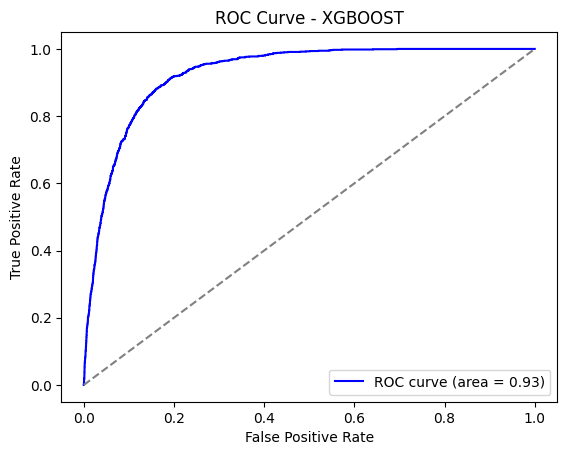

In [27]:
# Define models
models = {
    "LOGISTIC_REGRESSION": LogisticRegression(random_state=42),
    "RANDOM_FOREST": RandomForestClassifier(random_state=42),
    "XGBOOST": XGBClassifier(random_state=42),
    }

for name, model in models.items():
    evaluation(name,model)

# 3. Choosing final model and integrate it in pipeline for inferencing

I will choose for XGBoost. Why?

- Logistic regression performs slightly worse than the other 2 ones.
- Random Forest performs slightly worse than XGBoost. Besides, Random Forest is stored in a heavier file. This might not be relevant for local inferences,but it 
could create troubles in a potential deployment in a small instance in the cloud.

Let's try to achieve a little improvement of the model's performance by trying different hyperparameters with GridSearchCV. When this is done we will save the model with the most accurate hyperparameters. We can add as many hyperparameters and values as we want. However, too many combination would slow down the training process. I will just try some important hyperparameters, including the L1 and L2 regularization ones in order to avoid overfitting

In [28]:
def evaluation_grid_search():
    # Define cross-validation strategy (5-fold Stratified)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Define the model
    model = XGBClassifier(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 2],  # L1 regularization
        'reg_lambda': [0, 0.1, 0.5, 2]  # L2 regularization
        }

    # Create GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

    # Fit the model with GridSearchCV
    grid_search.fit(X_train, y_train)

    # Print the best parameters found by GridSearchCV
    print(f"Best Hyperparameters: {grid_search.best_params_}")

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Perform cross-validation and calculate mean accuracy for the best model
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"Cross-Validation Accuracy Scores: {cv_scores}")
    print(f"Mean Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

    # Fit the best model on the full training data
    best_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Best Model')
    plt.legend(loc='lower right')
    plt.show()

    # Save the most accurate model in a file for production
    pkl_filename = "models/optimized_xgboost.pkl"  
    with open(pkl_filename, 'wb') as file:  
        pickle.dump(best_model, file)

    return()

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.9}
Cross-Validation Accuracy Scores: [0.90863715 0.90928819 0.91057087 0.91556327 0.90688083]
Mean Accuracy: 0.9102 ± 0.0029
Test Set Accuracy: 0.9103
Confusion Matrix:
[[8507  254]
 [ 632  480]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8761
           1       0.65      0.43      0.52      1112

    accuracy                           0.91      9873
   macro avg       0.79      0.70      0.74      9873
weighted avg       0.90      0.91      0.90      9873



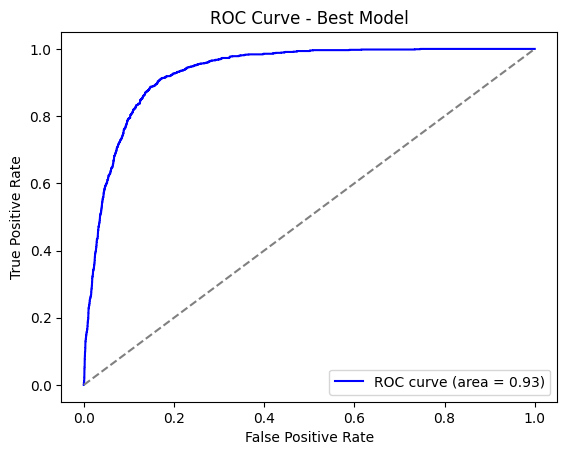

()

In [29]:
evaluation_grid_search()

# 4. Produce predictions and save them in predictions.csv

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier

We are going to summarize the data pipeline in a fuction so that we can apply it to any input:

In [ ]:
def pipeline(df):
    # Let's apply the changes for normalization etc:
    categorical_columns = [x for x in df.columns if df[x].dtype == np.dtype('object')]
    numerical_columns   = [x for x in df.columns if x not in(categorical_columns)]

    # we remove "month in order to label it manually with a perfect logic"
    categorical_columns.remove('month') 
    categorical_columns.remove('day_of_week') 

    data = {'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']}
    month_mapping = {'jan': 1,'feb': 2,'mar': 3,'apr': 4,'may': 5,'jun': 6,'jul': 7,'aug': 8,'sep': 9,'oct': 10,'nov': 11,'dec': 12}
    # Manually encode the "month" column
    df['month'] = df['month'].map(month_mapping)

    data = {'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri']}
    week_mapping = {'mon': 1,'tue': 2,'wed': 3,'thu': 4,'fri': 5,}
    # Manually encode the "day_of_week" column
    df['day_of_week'] = df['day_of_week'].map(week_mapping)

    df['duration']=df['duration']/60

    label_encoders = {}  # Store encoders for inverse transform if needed

    for col in categorical_columns:  # List of categorical columns
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])


    # List of numerical features to be standardized
    standarizable_features = ['age','campaign']
    # Initialize the StandardScaler
    with open("scaler/scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    # Standardize the numerical features
    df[standarizable_features] = scaler.transform(df[standarizable_features])

    return(df)

In [32]:
df = pd.read_excel('data/test_file.xlsx')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome
0,34,services,married,high.school,no,no,no,telephone,may,thu,214,4,0,nonexistent
1,29,blue-collar,single,basic.9y,no,no,no,cellular,jul,thu,190,1,0,nonexistent
2,35,admin.,single,high.school,no,no,no,cellular,may,wed,152,2,0,nonexistent
3,60,admin.,divorced,high.school,no,yes,no,cellular,jul,fri,179,1,0,nonexistent
4,45,management,married,university.degree,no,no,no,telephone,may,wed,105,2,0,nonexistent


In [33]:
df_final = pipeline(df)
df_final.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome
0,-0.578124,6,1,2,0,0,0,1,5,4,3.566667,0.522785,0,1
1,-1.058764,1,2,1,0,0,0,0,7,4,3.166667,-0.566819,0,1
2,-0.481996,0,2,2,0,0,0,0,5,3,2.533333,-0.203618,0,1
3,1.921206,0,0,2,0,2,0,0,7,5,2.983333,-0.566819,0,1
4,0.479285,3,1,4,0,0,0,1,5,3,1.750000,-0.203618,0,1


In [34]:
# Load the model
with open('models/optimized_xgboost.pkl', "rb") as file:
    loaded_model = pickle.load(file)
    
# Get predictions and probabilities
predictions = loaded_model.predict(df_final)
probabilities = loaded_model.predict_proba(df_final)
predicted_probs = (probabilities[:, 1] * 100).round(0).astype(int)  

# Create DataFrame
df_results = pd.DataFrame({
    "prediction": predictions,
    "probability of buying the product": predicted_probs.astype(str) + "%"  
})

df_results['prediction'] = df_results['prediction'].replace({0: 'no', 1: 'yes'})
df_results[['prediction']].to_csv('data/predictions.csv', index=False)

# Display the DataFrame
df_results

,prediction,probability of buying the product
0,no,0%
1,no,2%
2,no,2%
3,no,6%
4,no,0%
5,no,0%
6,no,0%
7,no,22%
8,yes,51%
9,no,0%


Index number 30 could almost be considered a yes since there is a 50% of probabilities of purchase

In order to address the question "Which features were most important to predict the target?" we are going to use the "feature_importances_" XGBoost property:

In [35]:
feature_importance = loaded_model.feature_importances_
# Create a DataFrame for better visualization
feature_names = df_final.columns  # Make sure df_final contains the same features used during training
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Display the top features
print(importance_df)

        Feature  Importance
13     poutcome    0.299303
10     duration    0.176213
7       contact    0.098776
12     previous    0.094170
4       default    0.078761
8         month    0.077641
0           age    0.036622
3     education    0.025207
9   day_of_week    0.023538
11     campaign    0.021771
2       marital    0.021172
1           job    0.019157
6          loan    0.015135
5       housing    0.012533


- The most important is "poutcome" which refers to "previous outcome", meaning result in previous campaign. It makes sense and indicates that
some people trusts on the bank and accept recomendation. 
- The second one is "duration" which makes sense because people who are interested in the bank term deposit will want to get more information about it and therefore the call will be longer.